# 1. Data Preprocessing

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

In [2]:
# Import data

def import_data(dir, norm=True):
    dfs = []
    min_val,max_val = (None,None)
    for file in os.listdir(dir):
        df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        df = df.drop(columns=[0])
        dfs.append(df)
        min_val = min(df.values.min(), min_val) if min_val else df.values.min()
        max_val = max(df.values.max(), max_val) if max_val else df.values.max()
    for i,df in enumerate(dfs):
        dfs[i] = (df-min_val)/(max_val-min_val)
        
    return dfs, min_val, max_val

train_dfs, train_min, train_max = import_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs, test_min, test_max = import_data("/Users/faith/Desktop/Projects/tsad/data/test")

In [3]:
# Convert to Tensors

train = torch.FloatTensor(train_dfs[0].values)
test = torch.FloatTensor(test_dfs[0].values)

In [4]:
# Create Dataset Class

class TimewindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return self.data.shape[0]-self.window_size
    
    def __getitem__(self,i):
        return (self.data[i:i+self.window_size], self.data[i+self.window_size])
    
window_size = 100
train_dataset = TimewindowDataset(train, window_size)
train_dataloader = DataLoader(train_dataset)

# 2. Model

In [16]:
# 1D Conv + 2 GATs + GRU + FFN

class GATModel(torch.nn.Module):
    def __init__(self, n, k, kernel_size=3, hidden_dim=256, n_layers=1):
        """
        n = number timesteps
        k = number sensors
        """
        super().__init__()
               
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.conv1 = nn.Conv1d(k, k, kernel_size)
        self.feature_conv1 = GATConv(n-kernel_size+1, n-kernel_size+1)
        self.time_conv1 = GATConv(k, k, dropout=0.05)
        #self.gru = nn.GRU((n-kernel_size+1)*3, hidden_dim, n_layers, batch_first=True, dropout=0.1)
        self.gru = nn.GRU(k*3, self.hidden_dim, n_layers, batch_first=True)
        #self.fc1 = nn.Linear((n-kernel_size+1)*self.hidden_dim, self.hidden_dim)
        self.fc1 = nn.Linear(3*k*(n-kernel_size+1), self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.fc3 = nn.Linear(self.hidden_dim, k)
        self.fc4 = nn.Linear(hidden_dim, k)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x,h):
        # 1. Sensor-wise Convolution
        x = self.sensor_conv(x)
        # 2. Parallel GAT
        x1 = self.feature_gat(x)
        x2 = self.time_gat(x)
        # 3. Concat x, x1, x2
        x = self.concat(x,x1,x2)
        # 4. GRU
        #x,h = self.gru(x,h)
        # 5. Forecasting Model
        # x.shape = n x hidden (representation of all sensors together). Flatten to consider all
        #x = torch.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        '''x = self.relu(x)
        x = self.fc4(x)'''
        
        # 6. Reconstruction Model
        
        return x,h
    
    def init_hidden(self,batch_size):
        return torch.zeros(self.n_layers,self.hidden_dim)
        
    def sensor_conv(self,x):
        """
        For each sensor, do a 1D convolution of kernel size 7.
        input: nxk
        output: kxn
        """
        return self.conv1(x.T)
    
    def complete_edge_idx(self, num_nodes):
        nodes = torch.tensor(list(range(num_nodes)))
        idx1 = nodes.repeat_interleave(num_nodes)
        idx2 = nodes.repeat(num_nodes)
        return torch.vstack((idx1,idx2))
        
    def feature_gat(self,x):
        """
        1 node for each sensor
        input: kxn
        output: kxn
        """
        edge_idx = self.complete_edge_idx(x.shape[0])
        data = Data(x=x, edge_index=edge_idx)
        x = self.feature_conv1(data.x, data.edge_index)
        return x
    
    def time_gat(self,x):
        """
        1 node for each timestep
        input: kxn
        output: nxk
        """
        x = x.T 
        edge_idx = self.complete_edge_idx(x.shape[0])
        data = Data(x=x, edge_index=edge_idx)
        x = self.time_conv1(data.x, data.edge_index)
        return x
    
    def concat(self,x,x1,x2):
        """
        Concatenate x, x1, x2
        input: kxn, kxn, nxk
        output: nx3k
        """
        return torch.hstack((x.T,x1.T,x2))
        

# 3. Training

In [17]:
n = window_size
k = train.shape[1]
# UPDATE: k = 1 for single sensor training
#k=1
learn_rate=1e-3
EPOCHS = 20
model = GATModel(n,k)
h = model.init_hidden(1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

In [18]:
for epoch in range(0,EPOCHS):
    for i,item in enumerate(train_dataloader):
        window, target = item
        window = window.squeeze()
        target = target.T.squeeze()

        x,h_new = model(window,h)
        h = h_new.data
        model.zero_grad()
        loss = None
        for sensor in range(target.shape[0]):
            if loss is None:
                loss = criterion(x[sensor],target[sensor])
            else:
                loss += criterion(x[sensor],target[sensor])
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(f"Epoch {epoch}, item {i}, loss {loss.item()}")

Epoch 0, item 0, loss 1.9005117416381836
Epoch 0, item 100, loss 0.0005637111607939005
Epoch 0, item 200, loss 0.0007207529852166772
Epoch 0, item 300, loss 0.00011047440057154745
Epoch 0, item 400, loss 0.0007513362797908485
Epoch 0, item 500, loss 0.0002878170635085553
Epoch 0, item 600, loss 0.00027594203129410744
Epoch 0, item 700, loss 0.00018685621034819633
Epoch 0, item 800, loss 0.000678431533742696
Epoch 0, item 900, loss 7.377602742053568e-05
Epoch 0, item 1000, loss 0.0003457156417425722
Epoch 0, item 1100, loss 0.00017269914678763598
Epoch 0, item 1200, loss 0.0004544698749668896
Epoch 0, item 1300, loss 0.0002212009858340025
Epoch 0, item 1400, loss 0.0013354618567973375
Epoch 0, item 1500, loss 0.0006372619536705315
Epoch 0, item 1600, loss 0.0003880312433466315
Epoch 0, item 1700, loss 0.00019521595095284283
Epoch 0, item 1800, loss 0.002495318418368697
Epoch 0, item 1900, loss 0.0005442458787001669
Epoch 0, item 2000, loss 0.0008401662926189601
Epoch 0, item 2100, loss 

KeyboardInterrupt: 

In [8]:
PATH = "gat_model.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

# 4. Eval

In [9]:
test = torch.FloatTensor(test_dfs[0].values)
test_dataset = TimewindowDataset(test, window_size)
test_dataloader = DataLoader(test_dataset)
prev_h = h

In [12]:
model.eval()
preds = None
targets = None
for i,item in enumerate(test_dataloader):
    window, target = item
    window = window.squeeze()
    target = target.T.squeeze()
    x,h_new = model(window,h)
    h = h_new.data
    print(x)
    if preds is None:
        preds = x.detach().numpy().reshape(-1)
    else:
        preds = np.vstack((preds,x.detach().numpy().reshape(-1)))
    if targets is None:
        targets = target.detach().numpy().reshape(-1)
    else:
        targets = np.vstack((targets,target.detach().numpy().reshape(-1)))
        

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.0120, 0.0322, 0.0331,
        0.0034, 0.0063, 0.0157, 0.0686, 0.0350, 0.0433, 0.0334, 0.1245, 0.0426,
        0.0233, 0.0134, 0.0178, 0.0175, 0.8991, 0.6575, 0.0252, 0.0034, 0.0162,
        0.0169, 0.0123, 0.0037, 0.6087, 0.0985], grad_fn=<AddBackward0>)
tensor([0.1723, 0.0822, 0.0240, 0.0841, 0.0098, 0.0091, 0.012

KeyboardInterrupt: 

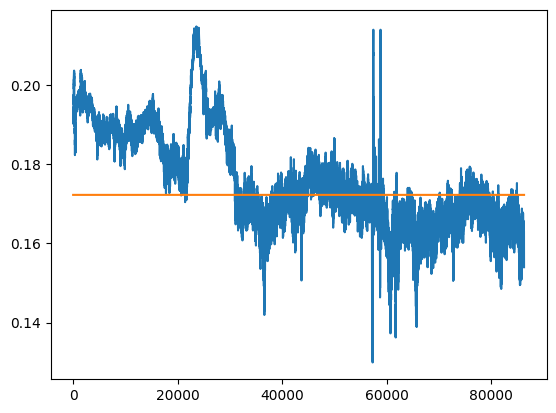

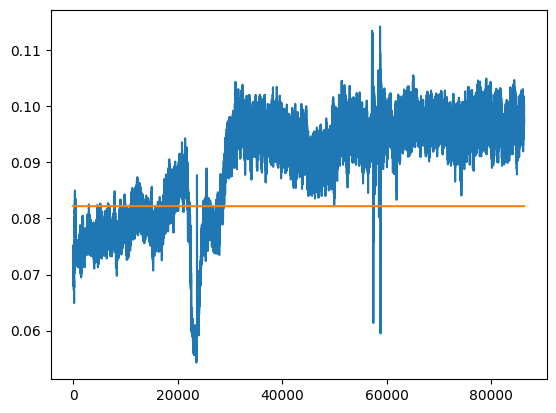

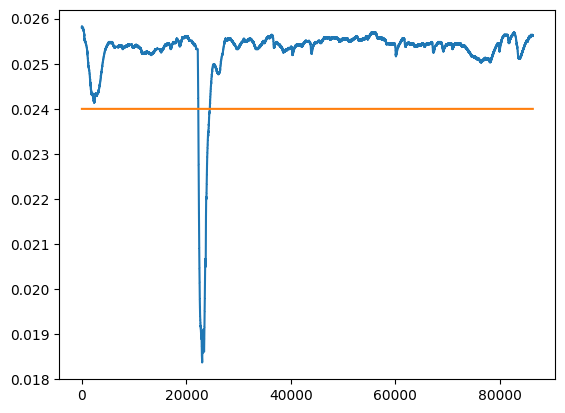

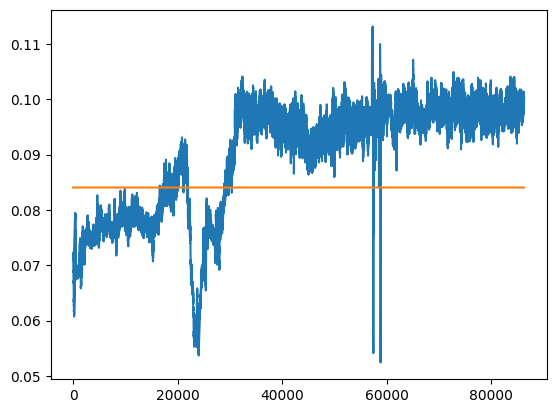

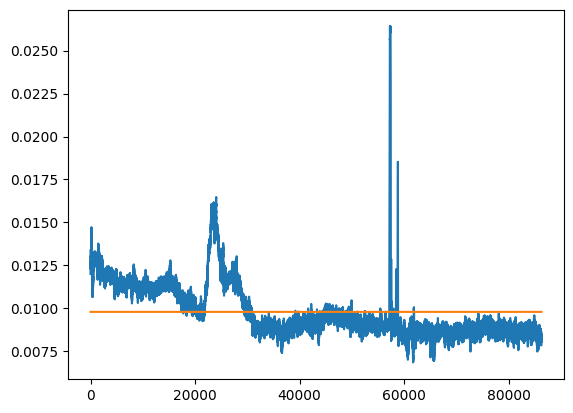

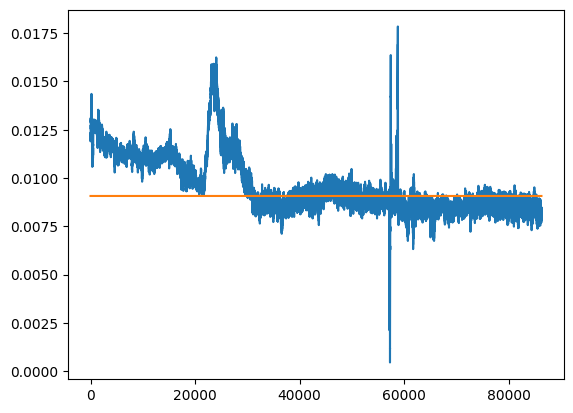

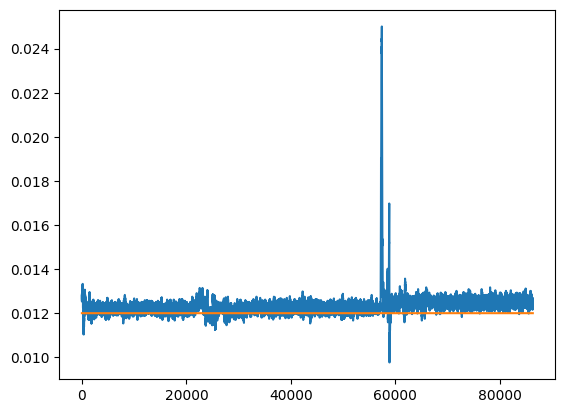

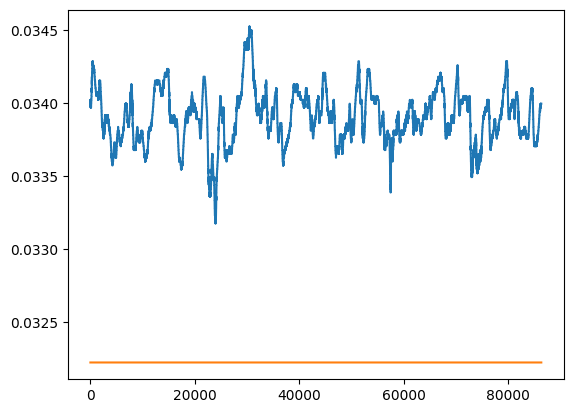

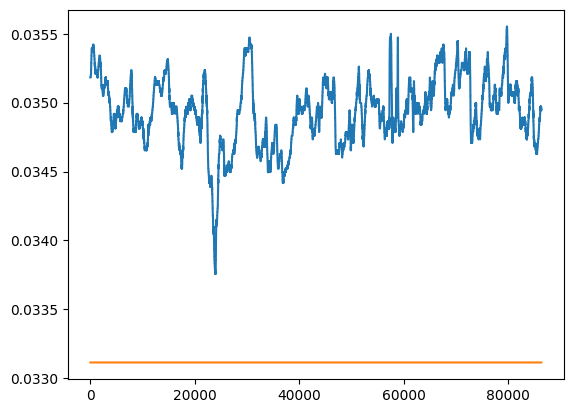

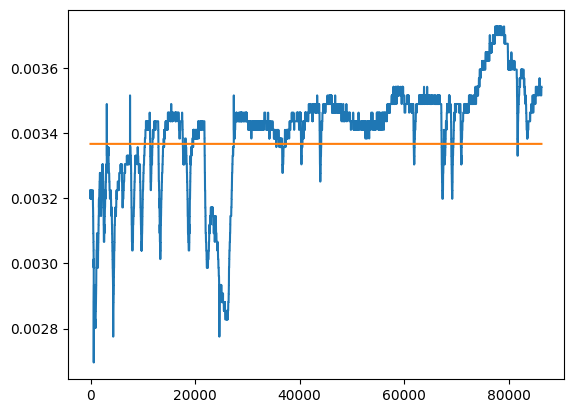

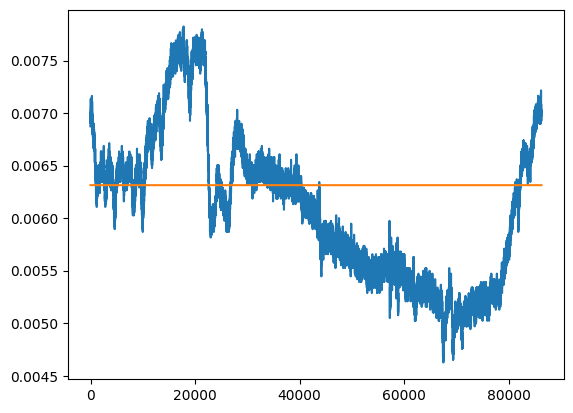

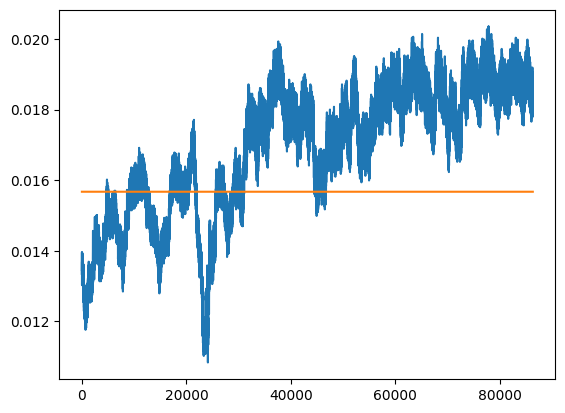

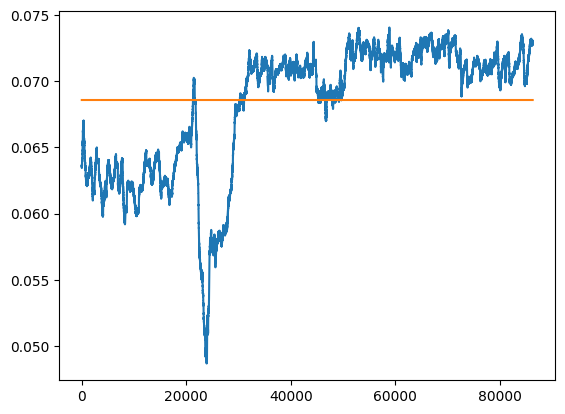

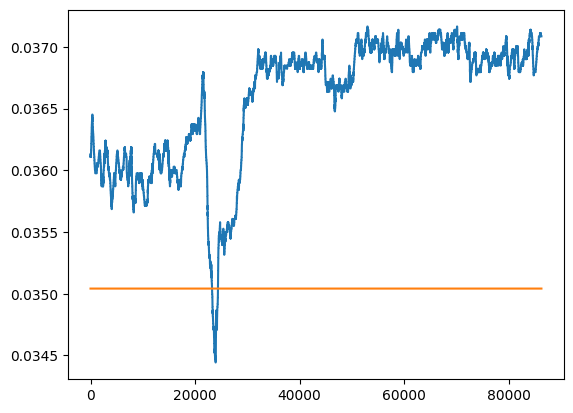

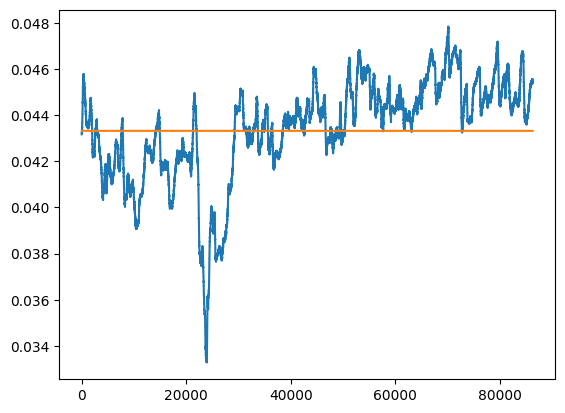

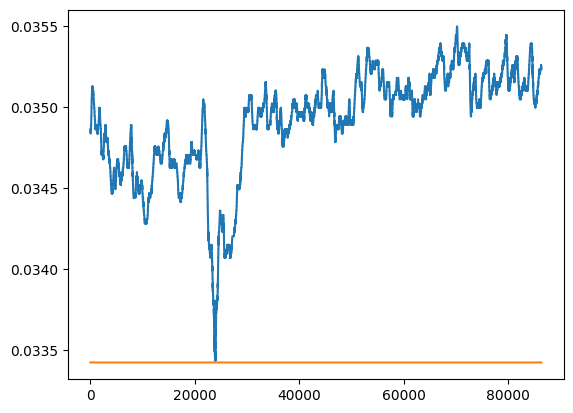

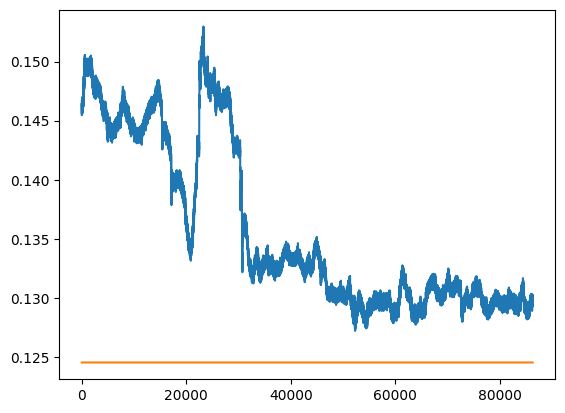

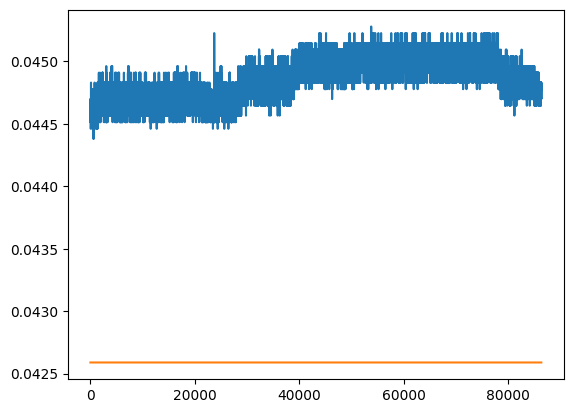

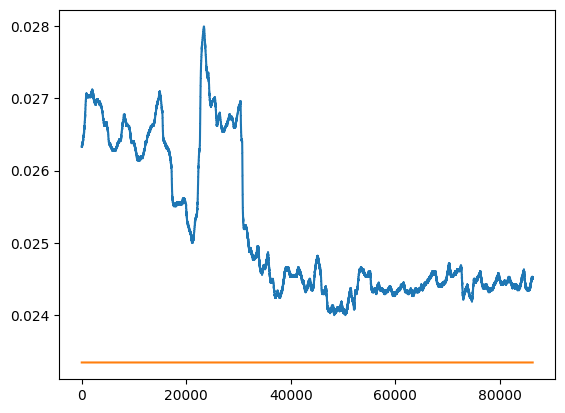

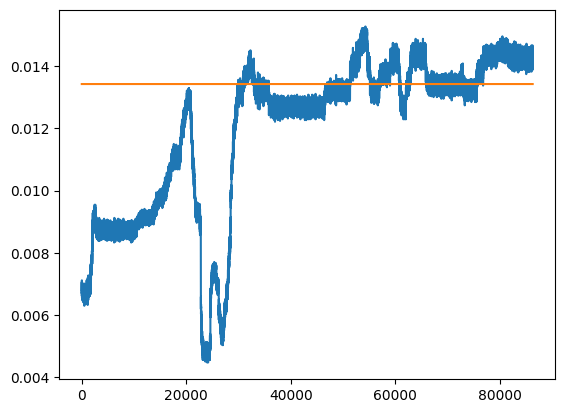

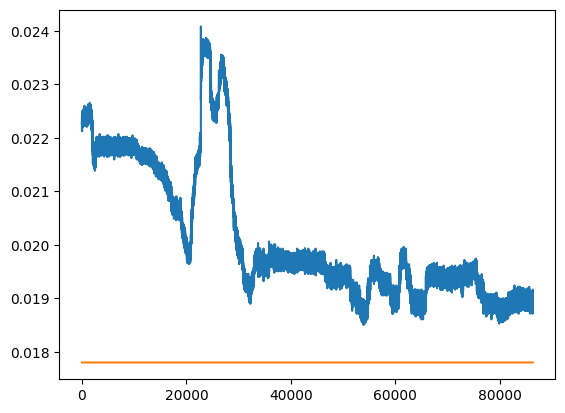

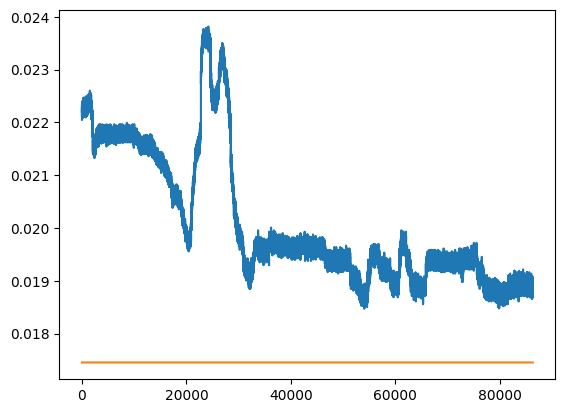

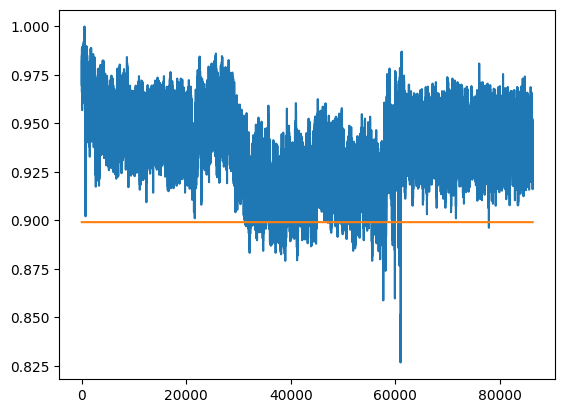

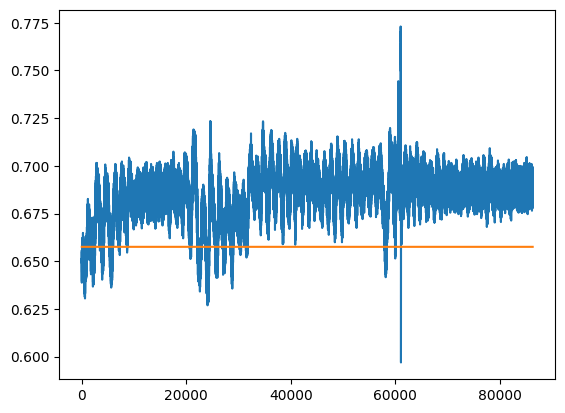

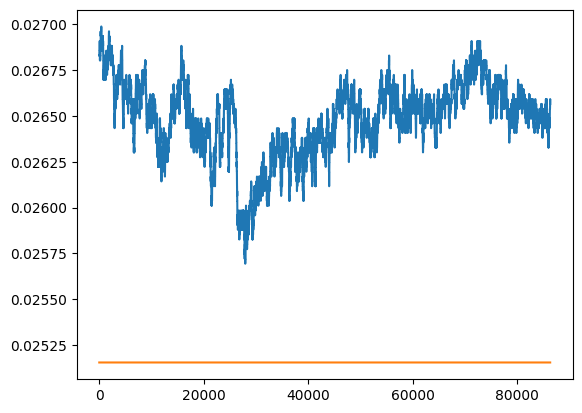

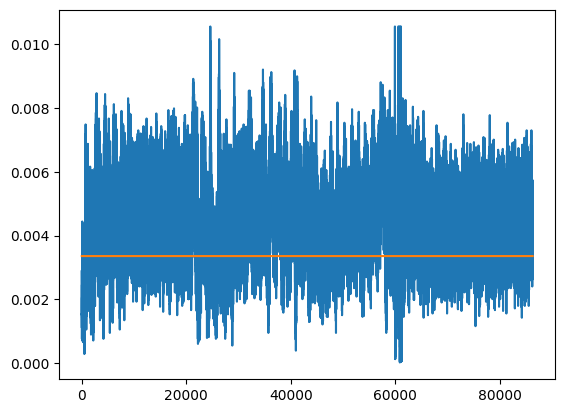

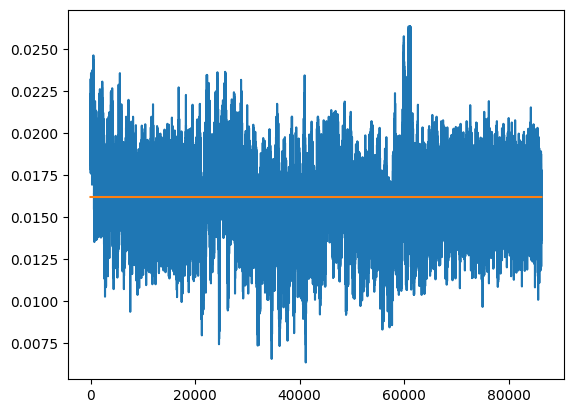

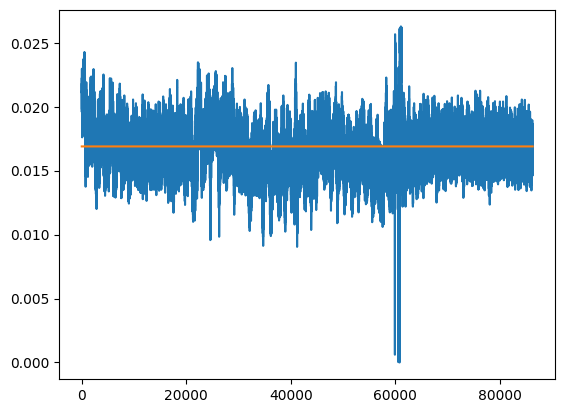

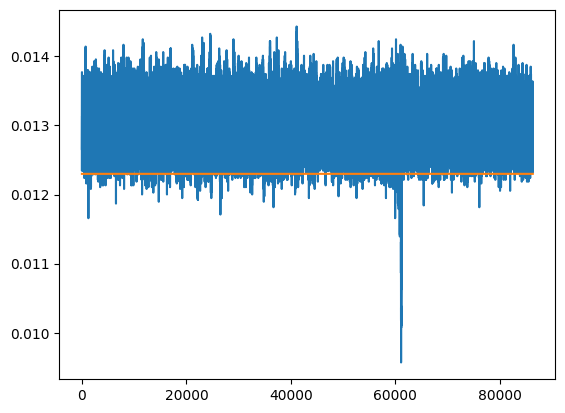

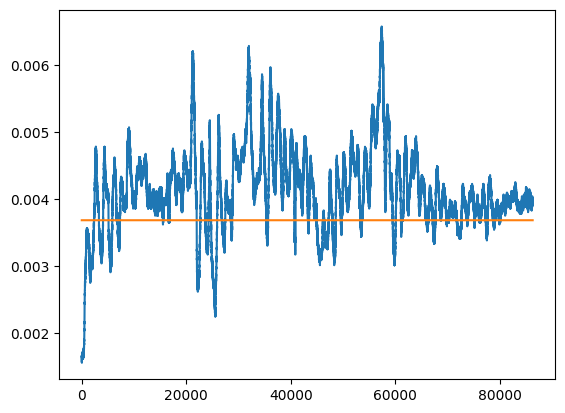

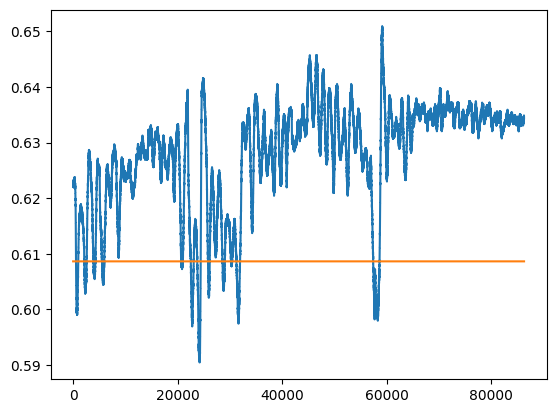

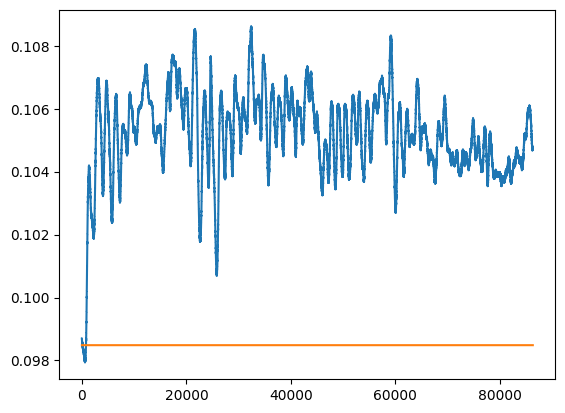

In [11]:
import matplotlib.pyplot as plt

for i in range(k):
    plt.plot(targets[1:,i])
    plt.plot(preds[1:,i])
    plt.show()